In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from __future__ import annotations

import json
import os
from collections import defaultdict
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Display config
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)


In [ ]:
def parse_metric_lists(metrics_df: pd.DataFrame) -> pd.DataFrame:
    """Parse list-valued metric columns that were serialized as strings."""

    def parse_value(value: Any) -> Any:
        if isinstance(value, str):
            stripped = value.strip()
            if stripped.startswith("[") and stripped.endswith("]"):
                inner = stripped[1:-1].strip()
                if not inner:
                    return []
                parsed_vals: list[float] = []
                for token in inner.split(","):
                    component = token.strip()
                    if not component:
                        continue
                    lowered = component.lower()
                    if lowered == "nan":
                        parsed_vals.append(np.nan)
                    elif lowered in {"inf", "+inf"}:
                        parsed_vals.append(np.inf)
                    elif lowered == "-inf":
                        parsed_vals.append(-np.inf)
                    else:
                        parsed_vals.append(float(component))
                return parsed_vals
        return value

    parsed = metrics_df.copy()
    for column in parsed.columns:
        if column == "system":
            continue
        parsed[column] = parsed[column].apply(parse_value)
    return parsed


def aggregate_system_metrics(metrics_df: pd.DataFrame) -> pd.DataFrame:
    """Collapse per-instance lists into per-system aggregates."""

    def aggregate_value(value: Any) -> Any:
        if isinstance(value, list):
            arr = np.asarray(value, dtype=float)
            if arr.size == 0:
                return np.nan
            return float(np.nanmean(arr))
        return value

    aggregated = metrics_df.copy()
    for column in aggregated.columns:
        if column == "system":
            continue
        aggregated[column] = aggregated[column].apply(aggregate_value)
    return aggregated


def list_system_names(system_dir: Path) -> list[str]:
    """Return sorted system names discovered in the provided directory."""
    if not system_dir.exists():
        raise FileNotFoundError(f"System directory not found: {system_dir}")
    return sorted(child.name for child in system_dir.iterdir() if child.is_dir())


def load_lyapunov_map(
    json_path: Path,
    bucket_key: str | int | None = "4096",
    metric_key: str = "max_lyap_rosenstein",
) -> dict[str, float]:
    """Load average Lyapunov exponents per system from JSON."""
    with json_path.open() as fh:
        data = json.load(fh)
    if bucket_key is None:
        key = next(iter(data))
        entries = data[key]
    else:
        entries = data[str(bucket_key)]

    lyap_values: dict[str, list[float]] = defaultdict(list)
    for system_name, metrics in entries:
        value = metrics.get(metric_key)
        if value is None:
            continue
        lyap_values[system_name].append(float(value))

    return {system: float(np.nanmean(values)) for system, values in lyap_values.items()}


def load_metrics_for_model(
    model_name: str, metrics_dir: Path
) -> tuple[dict[int, dict[str, list[float]]], dict[int, pd.DataFrame]]:
    """Load CSV metrics for a single model, returning aggregated and per-instance registries."""
    aggregated_registry: dict[int, dict[str, list[float]]] = {}
    instance_registry: dict[int, pd.DataFrame] = {}

    csv_paths = sorted(
        [path for path in metrics_dir.glob("*.csv")],
        key=lambda path: int(path.stem.split("_pred")[1]),
    )
    if not csv_paths:
        raise FileNotFoundError(f"No CSV metrics found in {metrics_dir}")

    for csv_path in csv_paths:
        prediction_length = int(csv_path.stem.split("_pred")[1])
        metrics_df = pd.read_csv(csv_path)
        parsed_metrics = parse_metric_lists(metrics_df)
        aggregated_metrics = aggregate_system_metrics(parsed_metrics)
        aggregated_registry[prediction_length] = aggregated_metrics.to_dict()
        instance_registry[prediction_length] = parsed_metrics

    return aggregated_registry, instance_registry


def build_instance_metric_dataframe(
    model_name: str,
    prediction_length: int,
    metric_name: str,
    instance_registry: dict[str, dict[int, pd.DataFrame]],
    systems: list[str] | None = None,
) -> pd.DataFrame:
    """Explode per-instance metrics for a specific model/prediction length."""
    if model_name not in instance_registry:
        raise KeyError(f"Model '{model_name}' not found in instance registry")
    model_metrics = instance_registry[model_name]
    if prediction_length not in model_metrics:
        raise KeyError(f"Prediction length {prediction_length} missing for model '{model_name}'")

    df = model_metrics[prediction_length]
    if metric_name not in df.columns:
        raise KeyError(f"Metric '{metric_name}' not available for model '{model_name}'")
    if systems is not None:
        df = df[df["system"].isin(systems)]

    records: list[dict[str, Any]] = []
    for row in df.itertuples(index=False):
        values = getattr(row, metric_name)
        if isinstance(values, np.ndarray):
            instance_values = values.tolist()
        elif isinstance(values, list):
            instance_values = values
        else:
            instance_values = [values]
        for instance_idx, value in enumerate(instance_values):
            records.append(
                {
                    "model": model_name,
                    "system": row.system,
                    "prediction_length": prediction_length,
                    "metric": metric_name,
                    "instance_index": instance_idx,
                    "value": value,
                    "system_dims": getattr(row, "system_dims", np.nan),
                    "n_system_samples": getattr(row, "n_system_samples", np.nan),
                }
            )
    return pd.DataFrame(records)


def compute_system_metric_summary(instance_df: pd.DataFrame) -> pd.DataFrame:
    """Compute summary statistics per system for the metric values."""
    summary = instance_df.groupby("system")["value"].agg(median="median", mean="mean", std="std", count="count")
    summary["sem"] = summary["std"] / np.sqrt(summary["count"])
    return summary


def plot_system_metric_distributions(
    instance_df: pd.DataFrame,
    metric_name: str,
    prediction_length: int,
    model_name: str,
    lyapunov_map: dict[str, float] | None = None,
    output_path: Path | None = None,
    figsize: tuple[float, float] = (20, 6),
) -> pd.DataFrame:
    """Create a per-system boxplot and optionally overlay Lyapunov exponents.

    Displays inline if output_path is None; otherwise saves to the provided path.
    """
    fig, ax = plt.subplots(figsize=figsize)

    if lyapunov_map is not None:
        systems = instance_df.system.unique()
        order = sorted(systems, key=lyapunov_map.__getitem__)
    else:
        medians = instance_df.groupby("system")["value"].median().sort_values()
        order = medians.index.tolist()

    df = instance_df.copy()
    df["system"] = pd.Categorical(df["system"], categories=order, ordered=True)
    df = df.sort_values("system")
    df.boxplot(column="value", by="system", ax=ax, rot=45, widths=0.8)
    ax.grid(False)

    if lyapunov_map is not None:
        ax2 = ax.twinx()
        lyaps = [lyapunov_map.get(sys, 0.0) for sys in systems]
        ax2.plot(range(1, len(systems) + 1), lyaps, "ro:")

    fig.tight_layout()
    if output_path is not None:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, bbox_inches="tight")
        print(f"Saved plot to {output_path}")
        plt.close(fig)
    else:
        plt.show()


In [143]:
work_dir = Path(os.getenv("WORK", "/stor/work/Gilpin"))

model_name = "Panda"
metric_name = "smape"
prediction_length = 64

metrics_dir = work_dir / "eval_results" / "patchtst" / "pft_chattn_emb_w_poly-0" / "test_zeroshot"
systems_dir = work_dir / "data" / "improved" / "final_base40" / "test_zeroshot"
lyapunov_json = Path("../../data/max_lyap_r_test_zeroshot.json")

In [144]:
# Load registries and system metadata
aggregated_registry, instance_registry = load_metrics_for_model(model_name, metrics_dir)
all_instance_metrics = {model_name: instance_registry}

systems = list_system_names(systems_dir)
lyapunov_map = load_lyapunov_map(lyapunov_json)

In [145]:
lyaps = defaultdict(list)
avg_lyaps = defaultdict(float)
for instance_name, lyap in lyapunov_map.items():
    system = instance_name.split("_")[0]
    lyaps[system].append(lyap)
avg_lyaps = {sys: sum(ls) / len(ls) for sys, ls in lyaps.items()}

['Coullet' 'Hopfield' 'HastingsPowell' 'KawczynskiStrizhak' 'SprottB'
 'MackeyGlass' 'HyperYangChen' 'Bouali' 'Rossler' 'LorenzStenflo'
 'OscillatingFlow' 'QiChen' 'CircadianRhythm' 'MacArthur' 'JerkCircuit'
 'DoublePendulum' 'Duffing' 'ChenLee' 'SprottR' 'SprottF']
[0.03513082161667346, 0.022912735680534785, 0.03755217196623692, 0.02229288109949031, 0.07794873063423674, 0.001440708896355107, 0.028903845049195943, 0.03540018184532686, 0.04698707544253282, 0.04779596345458985, 0.07859636340755265, 0.038834031257324195, 0.05694720826815248, 0.05402694236263078, 0.03345629978123657, 0.05964154706224309, 0.05554833034337435, 0.02979934294129203, 0.028022961379514086, 0.04972646588285344]
['MackeyGlass', 'KawczynskiStrizhak', 'Hopfield', 'SprottR', 'HyperYangChen', 'ChenLee', 'JerkCircuit', 'Coullet', 'Bouali', 'HastingsPowell', 'QiChen', 'Rossler', 'LorenzStenflo', 'SprottF', 'MacArthur', 'Duffing', 'CircadianRhythm', 'DoublePendulum', 'SprottB', 'OscillatingFlow']
[0.001440708896355107, 0

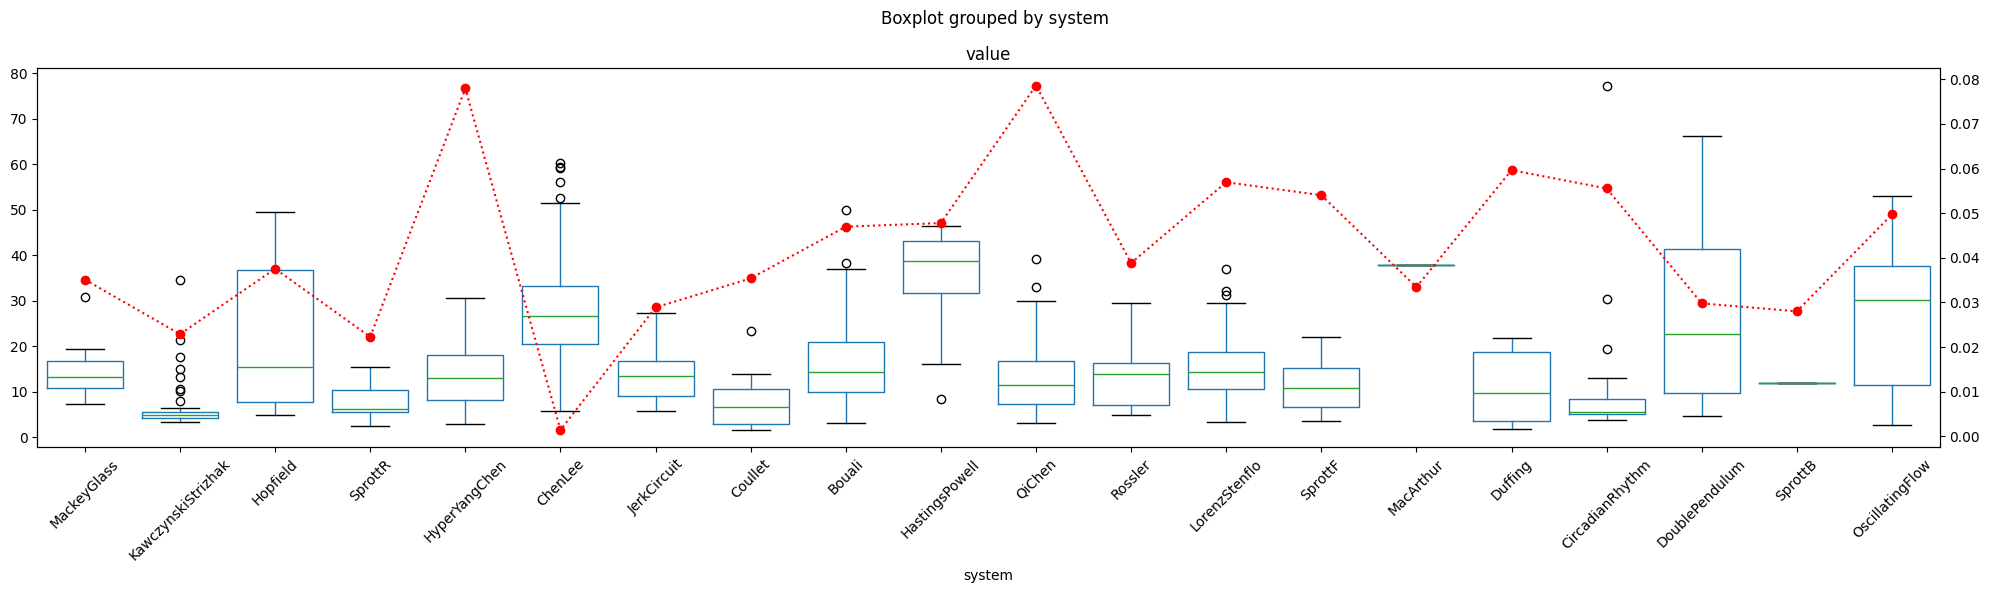

In [146]:
instance_df = build_instance_metric_dataframe(
    model_name=model_name,
    prediction_length=prediction_length,
    metric_name=metric_name,
    instance_registry=all_instance_metrics,
    systems=systems,
)
plot_system_metric_distributions(
    instance_df=instance_df,
    lyapunov_map=avg_lyaps,
    metric_name=metric_name,
    prediction_length=prediction_length,
    model_name=model_name,
)


In [94]:
lyapunov_map

{'LorenzStenflo_pp0': 0.024230272294883483,
 'LorenzStenflo_pp5': 0.020379995986035033,
 'LorenzStenflo_pp6': 0.025926478151092013,
 'LorenzStenflo_pp7': 0.04312230244390949,
 'LorenzStenflo_pp8': 0.05018656652112654,
 'LorenzStenflo_pp9': 0.021302405111771804,
 'LorenzStenflo_pp10': 0.04720869849723088,
 'LorenzStenflo_pp14': 0.03187981010379648,
 'LorenzStenflo_pp17': 0.018520337925817754,
 'LorenzStenflo_pp18': 0.050440375879406946,
 'LorenzStenflo_pp20': 0.036267348504940386,
 'LorenzStenflo_pp21': 0.03204283764711898,
 'LorenzStenflo_pp22': 0.020063889385166022,
 'LorenzStenflo_pp23': 0.035248831700169514,
 'LorenzStenflo_pp24': 0.036612719655933254,
 'LorenzStenflo_pp25': 0.06549800624090593,
 'LorenzStenflo_pp26': 0.04420429476837917,
 'LorenzStenflo_pp27': 0.023986064760308526,
 'LorenzStenflo_pp28': 0.03749951238470869,
 'LorenzStenflo_pp30': 0.03824465101150644,
 'LorenzStenflo_pp32': 0.03592270180246888,
 'LorenzStenflo_pp33': 0.030494703901441492,
 'LorenzStenflo_pp34': 0.0